In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from cuml.ensemble import RandomForestRegressor as cuRF
from sklearn.ensemble import RandomForestRegressor as RF
import cudf
import cupy
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scripts.function_utils import past_timesteps, test_leave_house_out, total_averaged_metrics, add_energy_variation

#### Output file

In [2]:
sourceFile = open("../../gpu_logs/not_hyp.txt", 'w')

### Load the data

In [3]:
df = pd.read_csv("../../data/porto.csv", decimal=",", index_col=[0])
df['Energy'] = df['Energy'].astype(np.float32)
df = df.iloc[:, [0, 2, 1]].reset_index(drop=True)
number_of_houses = df.Location.nunique()
df['Time'] = pd.to_datetime(df['Time'])
df.reset_index(drop=True, inplace=True)
df.Location = "Meter" + df['Location'].astype(str)
df

,Time,Location,Energy
0,2019-01-01 00:00:00,Meter0,2.964000
1,2019-01-01 00:15:00,Meter0,2.584000
2,2019-01-01 00:30:00,Meter0,3.071000
3,2019-01-01 00:45:00,Meter0,2.694000
4,2019-01-01 01:00:00,Meter0,2.569000
...,...,...,...
1791931,2020-01-01 22:45:00,Meter50,0.753222
1791932,2020-01-01 23:00:00,Meter50,0.716855
1791933,2020-01-01 23:15:00,Meter50,0.735802
1791934,2020-01-01 23:30:00,Meter50,0.485237


## Save Dataframe with past timesteps

In [ ]:
number_of_timesteps = 672

In [ ]:
df_new = past_timesteps(df, number_of_timesteps)
#df_new

In [ ]:
df_new['DayOfWeek'] = df_new['Time'].dt.dayofweek
df_new['Weekend'] = df_new['Time'].dt.dayofweek.isin([5, 6]).astype(int)
df_new['Hour'] = df_new['Time'].dt.hour
df_new

In [ ]:
X = df_new.drop(["Time", "Location", "Energy"], axis=1)
X

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
df_standardized = pd.DataFrame(scaler.transform(X), columns=X.columns)
df_standardized

In [ ]:
pca = PCA(n_components=20)
pca.fit(df_standardized)
df_pca = pd.DataFrame(pca.transform(df_standardized))
print(pca.explained_variance_ratio_)
df_pca

In [ ]:
not_features = pd.DataFrame(pd.concat([df_new['Time'], df_new["Location"], df_new["Energy"]], axis=1))
df_pca = pd.concat([not_features, df_pca], axis=1)
df_pca

In [ ]:
# df_selected = df_new[["Time","Location","lag_1","lag_2","lag_3","lag_4","lag_96","lag_192","lag_288","lag_384","lag_480","lag_576","lag_672","DayOfWeek","Hour","Energy"]]
# df_selected

In [ ]:
#df_selected.to_csv("../../data/porto_full_selected.csv", index=False)

## Predict  5 folds with 10 random houses for test

In [4]:
df_test = pd.read_csv("../../data/porto_full_selected.csv", nrows=100)

float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}

df = pd.read_csv("../../data/porto_full_selected.csv", engine='c', dtype=float32_cols)
df.Location = "Meter" + df['Location'].astype(str)
df

,Time,Location,lag_1,lag_2,lag_3,lag_4,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672,DayOfWeek,Hour,Energy
0,2019-01-08 00:00:00,Meter0,3.952000,3.803000,4.095000,3.926000,2.615000,3.321000,3.066000,2.351000,2.851000,3.054000,2.964000,1,0,4.940000
1,2019-01-08 00:15:00,Meter0,4.940000,3.952000,3.803000,4.095000,2.634000,2.873000,3.152000,2.843000,3.102000,2.677000,2.584000,1,0,4.149000
2,2019-01-08 00:30:00,Meter0,4.149000,4.940000,3.952000,3.803000,3.052000,3.407000,2.633000,2.949000,2.546000,3.522000,3.071000,1,0,4.401000
3,2019-01-08 00:45:00,Meter0,4.401000,4.149000,4.940000,3.952000,2.893000,2.673000,2.590000,2.605000,3.016000,2.729000,2.694000,1,0,4.431000
4,2019-01-08 01:00:00,Meter0,4.431000,4.401000,4.149000,4.940000,2.349000,2.390000,2.330000,3.023000,3.031000,2.368000,2.569000,1,1,3.988000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757659,2020-01-01 22:45:00,Meter50,1.099100,0.453906,0.481770,0.483173,0.641933,0.778195,0.753222,0.641933,0.778195,0.753222,1.723943,2,22,0.753222
1757660,2020-01-01 23:00:00,Meter50,0.753222,1.099100,0.453906,0.481770,0.752850,0.931837,0.716855,0.752850,0.931837,0.716855,1.482914,2,23,0.716855
1757661,2020-01-01 23:15:00,Meter50,0.716855,0.753222,1.099100,0.453906,0.935428,0.937079,0.735802,0.935428,0.937079,0.735802,1.772033,2,23,0.735802
1757662,2020-01-01 23:30:00,Meter50,0.735802,0.716855,0.753222,1.099100,0.715781,0.803087,0.485237,0.715781,0.803087,0.485237,2.535657,2,23,0.485237


In [5]:
num_houses_test = 10
locations = []
for i in range(10):
    np.random.seed(i*42)
    l = np.random.choice(df['Location'].unique(), size=num_houses_test, replace=False)
    locations.append(l)
locations

[array(['Meter29', 'Meter11', 'Meter10', 'Meter22', 'Meter2', 'Meter28',
        'Meter45', 'Meter32', 'Meter26', 'Meter4'], dtype=object),
 array(['Meter43', 'Meter40', 'Meter46', 'Meter12', 'Meter24', 'Meter31',
        'Meter17', 'Meter32', 'Meter3', 'Meter30'], dtype=object),
 array(['Meter35', 'Meter30', 'Meter37', 'Meter7', 'Meter6', 'Meter38',
        'Meter11', 'Meter19', 'Meter5', 'Meter22'], dtype=object),
 array(['Meter35', 'Meter2', 'Meter32', 'Meter5', 'Meter49', 'Meter7',
        'Meter15', 'Meter24', 'Meter25', 'Meter33'], dtype=object),
 array(['Meter30', 'Meter35', 'Meter11', 'Meter39', 'Meter16', 'Meter4',
        'Meter3', 'Meter24', 'Meter18', 'Meter10'], dtype=object),
 array(['Meter26', 'Meter34', 'Meter19', 'Meter15', 'Meter2', 'Meter16',
        'Meter23', 'Meter31', 'Meter13', 'Meter0'], dtype=object),
 array(['Meter39', 'Meter17', 'Meter1', 'Meter26', 'Meter11', 'Meter43',
        'Meter16', 'Meter29', 'Meter23', 'Meter20'], dtype=object),
 array(['Meter36', '

In [6]:
## Number of NaNs
df.isna().sum().sum()

0

In [7]:
#kf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42) 
#locations = []
#for _, test_index in kf.split(df['Location'].unique()):
#    locations.append(test_index)
#locations

In [8]:
n_splits = 10

### Linear Regression

In [ ]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_lr = test_leave_house_out(df, LinearRegression(), locations[i], sourceFile, split_timeseries=True, cv=i)
    metrics_list_lr.append((rmse, wape, r2))

In [ ]:
metrics_list_lr_pca = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_lr = test_leave_house_out(df_pca, LinearRegression(), locations[i], sourceFile, split_timeseries=True, cv=i)
    metrics_list_lr_pca.append((rmse, wape, r2))

In [ ]:
metrics_list_lr_loc = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_lr = test_leave_house_out(df, LinearRegression(), locations[i], sourceFile, split_timeseries=False)
    metrics_list_lr_loc.append((rmse, wape, r2))

In [ ]:
metrics_list_lr_pca_loc = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_lr = test_leave_house_out(df_pca, LinearRegression(), locations[i], sourceFile, split_timeseries=False)
    metrics_list_lr_pca_loc.append((rmse, wape, r2))

### XGBoost

In [ ]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0, colsample_bytree=0.7, learning_rate=0.01, max_depth=16, n_estimators=700), locations[i], sourceFile, split_timeseries=True, cv=i)
    metrics_list_xgb.append((rmse, wape, r2))

In [ ]:
metrics_list_xgb_pca = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_xgb = test_leave_house_out(df_pca, xgb.XGBRegressor(tree_method='gpu_hist', seed=0, colsample_bytree=0.7, learning_rate=0.01, max_depth=16, n_estimators=700), locations[i], sourceFile, split_timeseries=True, cv=i)
    metrics_list_xgb_pca.append((rmse, wape, r2))

In [9]:
metrics_list_xgb_loc = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0, colsample_bytree=0.7, learning_rate=0.01, max_depth=16, n_estimators=700), locations[i], sourceFile, split_timeseries=False)
    metrics_list_xgb_loc.append((rmse, wape, r2))


Iteration 0
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.3514
WAPE: 22.58
R2: 0.8732

Iteration 1
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.3721
WAPE: 23.62
R2: 0.8526

Iteration 2
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.3489
WAPE: 19.93
R2: 0.8849

Iteration 3
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.3760
WAPE: 21.93
R2: 0.8493

Iteration 4
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.3227
WAPE: 19.60
R2: 0.8841

Iteration 5
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 1.0496
WAPE: 19.76
R2: 0.5951

Iteration 6
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.3102
WAPE: 20.65
R2: 0.8836

Iteration 7
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.2433
WAPE: 18.86
R2: 0.9184

Iteration 8
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.33

In [10]:
metrics_list_xgb_loc_not_hyp = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0), locations[i], sourceFile, split_timeseries=False)
    metrics_list_xgb_loc_not_hyp.append((rmse, wape, r2))


Iteration 0
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.4714
WAPE: 31.14
R2: 0.7718

Iteration 1
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.4441
WAPE: 29.72
R2: 0.7901

Iteration 2
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.5157
WAPE: 30.35
R2: 0.7488

Iteration 3
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.4740
WAPE: 29.20
R2: 0.7606

Iteration 4
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.4504
WAPE: 29.11
R2: 0.7745

Iteration 5
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 1.0664
WAPE: 24.65
R2: 0.5820

Iteration 6
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.4532
WAPE: 30.71
R2: 0.7516

Iteration 7
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.4088
WAPE: 30.73
R2: 0.7697

Iteration 8
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.47

In [ ]:
metrics_list_xgb_pca_loc = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_xgb = test_leave_house_out(df_pca, xgb.XGBRegressor(tree_method='gpu_hist', seed=0, colsample_bytree=0.7, learning_rate=0.01, max_depth=16, n_estimators=700), locations[i], sourceFile, split_timeseries=False)
    metrics_list_xgb_pca_loc.append((rmse, wape, r2))

### Random Forest

In [ ]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_rf = test_leave_house_out(df, cuRF(bootstrap=True, max_depth=16, min_samples_leaf=1, min_samples_split=2,n_estimators=700), locations[i], sourceFile, split_timeseries=True, cv=i, gpu=False)
    metrics_list_rf.append((rmse, wape, r2))

In [ ]:
metrics_list_rf_pca = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_rf = test_leave_house_out(df_pca, cuRF(bootstrap=True, max_depth=16, min_samples_leaf=1, min_samples_split=2,n_estimators=700), locations[i], sourceFile, split_timeseries=True, cv=i, gpu=False)
    metrics_list_rf_pca.append((rmse, wape, r2))

In [11]:
metrics_list_rf_loc = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_rf = test_leave_house_out(df, cuRF(bootstrap=True, max_depth=16, min_samples_leaf=1, min_samples_split=2,n_estimators=700), locations[i], sourceFile, split_timeseries=False, gpu=False)
    metrics_list_rf_loc.append((rmse, wape, r2))


Iteration 0
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.4377
WAPE: 28.91
R2: 0.8033

Iteration 1
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.4106
WAPE: 27.85
R2: 0.8205

Iteration 2
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.4539
WAPE: 26.92
R2: 0.8053

Iteration 3
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.4478
WAPE: 27.09
R2: 0.7863

Iteration 4
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.3913
WAPE: 26.12
R2: 0.8297

Iteration 5
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 1.0837
WAPE: 23.31
R2: 0.5684

Iteration 6
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.3983
WAPE: 27.82
R2: 0.8082

Iteration 7
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.3443
WAPE: 27.07
R2: 0.8366

Iteration 8
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.4180
WAPE: 26.71
R2: 0.8231

Iteration 9
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.3125
WAPE: 27.58
R2: 0.8285


In [12]:
metrics_list_rf_loc_not_hyp = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_rf = test_leave_house_out(df, cuRF(), locations[i], sourceFile, split_timeseries=False, gpu=False)
    metrics_list_rf_loc_not_hyp.append((rmse, wape, r2))


Iteration 0
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.4400
WAPE: 28.98
R2: 0.8012

Iteration 1
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.4124
WAPE: 27.95
R2: 0.8190

Iteration 2
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.4528
WAPE: 26.97
R2: 0.8063

Iteration 3
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.4499
WAPE: 27.17
R2: 0.7843

Iteration 4
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.3934
WAPE: 26.20
R2: 0.8279

Iteration 5
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 1.0835
WAPE: 23.36
R2: 0.5685

Iteration 6
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.3995
WAPE: 27.89
R2: 0.8070

Iteration 7
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.3454
WAPE: 27.12
R2: 0.8356

Iteration 8
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 0.4191
WAPE: 26.77
R2: 0.8222

Iteration 9
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.3148
WAPE: 27.63
R2: 0.8260


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


In [ ]:
metrics_list_rf_pca_loc = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_rf = test_leave_house_out(df_pca, cuRF(bootstrap=True, max_depth=16, min_samples_leaf=1, min_samples_split=2,n_estimators=700), locations[i], sourceFile, split_timeseries=False, gpu=False)
    metrics_list_rf_pca_loc.append((rmse, wape, r2))

## Averaged Metrics

In [ ]:
print("\n\n\n", file=sourceFile)

In [ ]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)
total_averaged_metrics(metrics_list_lr_pca, sourceFile)
total_averaged_metrics(metrics_list_lr_loc, sourceFile)
total_averaged_metrics(metrics_list_lr_pca_loc, sourceFile)

In [13]:
print("\nXGBoost", file=sourceFile)
#total_averaged_metrics(metrics_list_xgb, sourceFile)
#total_averaged_metrics(metrics_list_xgb_pca, sourceFile)
total_averaged_metrics(metrics_list_xgb_loc, sourceFile)
total_averaged_metrics(metrics_list_xgb_loc_not_hyp, sourceFile)
#total_averaged_metrics(metrics_list_xgb_pca_loc, sourceFile)

Total Averaged RMSE: 0.397
Total Averaged WAPE: 20.857
Total Averaged R2: 0.851
Total Averaged RMSE: 0.509
Total Averaged WAPE: 29.493
Total Averaged R2: 0.753


(0.509, 29.493, 0.753)

In [14]:
print("\nRandom Forest", file=sourceFile)
#total_averaged_metrics(metrics_list_rf, sourceFile)
#total_averaged_metrics(metrics_list_rf_pca, sourceFile)
total_averaged_metrics(metrics_list_rf_loc, sourceFile)
total_averaged_metrics(metrics_list_rf_loc_not_hyp, sourceFile)
#total_averaged_metrics(metrics_list_rf_pca_loc, sourceFile)

Total Averaged RMSE: 0.47
Total Averaged WAPE: 26.938
Total Averaged R2: 0.791
Total Averaged RMSE: 0.471
Total Averaged WAPE: 27.004
Total Averaged R2: 0.79


(0.471, 27.004, 0.79)

In [15]:
sourceFile.close()

### Feature Importance

In [11]:
print('XGBoost\n')
for i,v in enumerate(model_xgb.feature_importances_):
    print('Feature: %0d, Score: %.5f' % (i,v))

XGBoost

Feature: 0, Score: 0.49140
Feature: 1, Score: 0.10580
Feature: 2, Score: 0.04320
Feature: 3, Score: 0.02314
Feature: 4, Score: 0.03137
Feature: 5, Score: 0.03002
Feature: 6, Score: 0.06270
Feature: 7, Score: 0.04422
Feature: 8, Score: 0.02134
Feature: 9, Score: 0.02468
Feature: 10, Score: 0.02567
Feature: 11, Score: 0.07248
Feature: 12, Score: 0.02396


In [12]:
model_xgb.feature_importances_

array([0.49140155, 0.10580443, 0.04320302, 0.02314029, 0.03136947,
       0.03002426, 0.06270386, 0.04421767, 0.02133822, 0.02467958,
       0.02567356, 0.07248212, 0.0239619 ], dtype=float32)

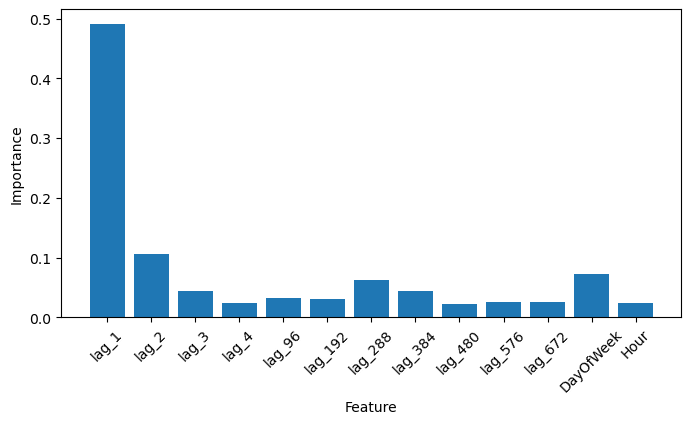

In [9]:
plt.figure(figsize=(8,4))
plt.bar(df.columns[2:-1],model_xgb.feature_importances_)
#plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.savefig("../../images/main/porto_xgb_feat_imp_loc.png")
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(df.columns[2:-1],model_lr.coef_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [ ]:
columns = df.drop(["Energy", "Location", "Time"], axis=1).columns
feature_importance = pd.Series(model_xgb.feature_importances_, index=columns)
feature_importance

In [ ]:
features = feature_importance.nlargest(40).index
features

In [ ]:
df_40 = df[['Time', 'Location'] + [*features] + ['Energy']]
df_40

In [ ]:
df_40.to_csv("data/porto_best40features.csv", index=False)

## Hyperparameter Tuning

In [ ]:
df_test = pd.read_csv("../../data/porto_full_selected.csv", nrows=100)

float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}

df_tuning = pd.read_csv("../../data/porto_full_selected.csv", engine='c', dtype=float32_cols)
df_tuning.drop(['Time', 'Location'], axis=1, inplace=True)
df_tuning

In [ ]:
undersample_data = df_tuning.loc[np.linspace(df_tuning.index.min(),df_tuning.index.max(),400000).astype(int)]
#undersample_time = df_index.loc[np.linspace(df_index.index.min(),df_index.index.max(),8784).astype(int)]
undersample_data = undersample_data.reset_index().drop('index',axis=1)
undersample_data

In [ ]:
params_rf = {
    'bootstrap': [True],
    'max_depth': [8, 12, 16],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 8, 10],
    'n_estimators': [500, 700]
}

In [ ]:
params_xgb = { 
    'max_depth': [10, 16],
    'learning_rate': [0.001, 0.01, 0.05],
    'n_estimators': [500, 700],
    'colsample_bytree': [0.3, 0.7]
}

In [ ]:
train_features = undersample_data.drop('Energy', axis=1)
train_labels = undersample_data['Energy']
test_features = 0
test_labels = 0

### XGBoost Best Parameters

In [ ]:
xgb_model = xgb.XGBRegressor(tree_method="gpu_hist", seed=42)
grid_search = GridSearchCV(estimator = xgb_model, param_grid = params_xgb, cv = 3, n_jobs = 4, verbose = 2, scoring="r2")

In [ ]:
grid_search.fit(train_features, train_labels)

In [ ]:
grid_search.best_params_
#{'colsample_bytree': 0.7,
#'learning_rate': 0.1,
#'max_depth': 10,
#'n_estimators': 1000}

In [ ]:
{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 16,
 'n_estimators': 700}

In [ ]:
grid_search.best_score_

### Random Forest Best Parameters

In [ ]:
rf = cuRF()
grid_search_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 3, n_jobs = 8, verbose = 2, scoring="r2")

In [ ]:
grid_search_rf.fit(train_features, train_labels)

In [ ]:
print(grid_search_rf.best_params_)
best_grid = grid_search_rf.best_estimator_
#grid_accuracy = evaluate(best_grid, test_features, test_labels)

In [ ]:
filee = open("rf_params.txt","w")
print(grid_search.best_params_, file=filee)
filee.close()

In [ ]:
{'bootstrap': True, 'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 700}